In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import implicit
import random
import matplotlib.pyplot as plt

# Capstone Project: Recommender System for The Cheese Shop Pte. Ltd. Part 2

# Modelling

In [2]:
df=pd.read_csv("../dataset/combined.csv")

In [3]:
df.head()

,transaction_id,product_id,product_name,product_qty,product_total_price
0,103,81,Keen's Cheddar,1.0,$35.00
1,103,83,Colston Basset Shropshire,1.0,$17.50
2,103,85,Reypenaer V.S.O.P. Gouda,1.0,$27.50
3,103,87,Sharpham Rustic,1.0,$18.75
4,104,82,Colston Bassett Stilton,1.0,$17.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50336 entries, 0 to 50335
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       50336 non-null  object 
 1   product_id           50336 non-null  object 
 2   product_name         50336 non-null  object 
 3   product_qty          50336 non-null  float64
 4   product_total_price  50336 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


In [5]:
# grouping df and parsing thru df for items with quantities of 0, and replacing them with quantitiy of at least 1
grouped_df = df[['transaction_id', 'product_id', 'product_name', 'product_qty']].groupby(['transaction_id', 'product_id', 'product_name']).sum().reset_index()
grouped_df.loc[grouped_df['product_qty'] == 0, ['product_qty']] = 1
grouped_df = grouped_df.loc[grouped_df['product_qty'] > 0]

In [6]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49973 entries, 0 to 49983
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  49973 non-null  object 
 1   product_id      49973 non-null  object 
 2   product_name    49973 non-null  object 
 3   product_qty     49973 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [7]:
# Assigning a transaction id that's more sequential
unique_transactions = grouped_df['transaction_id'].unique()
transaction_ids = dict(zip(unique_transactions, np.arange(unique_transactions.shape[0], dtype=np.int32)))

# Assigning a product id that's more sequential
unique_products = grouped_df['product_id'].unique()
product_ids = dict(zip(unique_products, np.arange(unique_products.shape[0], dtype=np.int32)))

grouped_df['unique_transaction_id'] = grouped_df['transaction_id'].apply(lambda i: transaction_ids[i])
grouped_df['unique_product_id'] = grouped_df['product_id'].apply(lambda i: product_ids[i])

In [8]:
grouped_df.head()

,transaction_id,product_id,product_name,product_qty,unique_transaction_id,unique_product_id
0,1000,244,College White with Truffles,1.0,0,0
1,10005,1037,Cottage Delight Classic Cheese Board Chutney M...,1.0,1,1
2,10005,425,Brillat Savarin with Truffles,1.0,1,2
3,10005,600,Iberico Ham (Sliced) 100g,1.0,1,3
4,10005,653,Brie with Truffles,1.0,1,4


In [9]:
#creating product x transaction sparse matrix
sparse_product_transaction = sparse.csr_matrix((grouped_df['product_qty'].astype(float), (grouped_df['unique_product_id'], grouped_df['unique_transaction_id'])))
#creating transaction x product sparse matrix
sparse_transaction_product = sparse.csr_matrix((grouped_df['product_qty'].astype(float), (grouped_df['unique_transaction_id'], grouped_df['unique_product_id'])))

In [10]:
sparse_product_transaction

<1560x10982 sparse matrix of type '<class 'numpy.float64'>'
	with 47999 stored elements in Compressed Sparse Row format>

In [11]:
sparse_transaction_product

<10982x1560 sparse matrix of type '<class 'numpy.float64'>'
	with 47999 stored elements in Compressed Sparse Row format>

In [12]:
# instantiating model with alternating least square method
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_transaction_product * alpha).astype('double')

#fitting data
model.fit(data)

100%|███████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


## Modelling - Similar Items 

In [13]:
# checking up on product ID 20 for later reference
grouped_df.loc[grouped_df['unique_product_id'] == 20].head()

,transaction_id,product_id,product_name,product_qty,unique_transaction_id,unique_product_id
22,10015,237,Tomme de Savoie,1.0,7,20
173,10058,237,Tomme de Savoie,1.0,41,20
345,10106,237,Tomme de Savoie,1.0,71,20
634,10203,237,Tomme de Savoie,4.0,134,20
1374,10400,237,Tomme de Savoie,1.0,280,20


In [14]:
unique_product_id = 20
#we're getting top 10 similar
n_similar = 10

item_vecs = model.item_factors
customer_vecs = model.user_factors

item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

scores = item_vecs.dot(item_vecs[unique_product_id]) / item_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[unique_product_id]), key=lambda x: -x[1])

for item in similar:
    idx, score = item
    print(grouped_df['product_name'].loc[grouped_df['unique_product_id'] == idx].iloc[0])

Tomme de Savoie
Granda Wild's Oaty Biscuit - Tomato & Linseed
Saint Nectaire
Petit Reblochon de Savoie
Ossau Iraty AOP Été (Summer) 2015
Fine Fleur de Celles
Le Skieur
Chabichou du Poitou
Reblochon Fermier
L'Etivaz


Comment:

Tomme de Savoie is a french hard cheese, most of the cheese that were shown, are french hard cheese too

## Modelling - Recommendations to Customer

In [15]:
# creating function for reommendations to customers

def recommend(unique_transaction_id, sparse_transaction_product, customer_vecs, item_vecs, num_items=10):
    
    transaction_interactions = sparse_transaction_product[unique_transaction_id,:].toarray()
    transaction_interactions = transaction_interactions.reshape(-1) + 1
    transaction_interactions[transaction_interactions > 1] = 0
    
    rec_vector = customer_vecs[unique_transaction_id,:].dot(item_vecs.T).toarray()
    
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = transaction_interactions * rec_vector_scaled

    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
    
    descriptions = []
    scores = []

    for idx in item_idx:
        descriptions.append(grouped_df['product_name'].loc[grouped_df['unique_product_id'] == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'Products': descriptions, 'Recommendation Score': scores})

    return recommendations

In [16]:
#checking out a certain transaction
unique_transaction_id = 7
grouped_df.loc[grouped_df['unique_transaction_id'] == unique_transaction_id].sort_values('product_qty', ascending=False)[['unique_transaction_id', 'product_name', 'product_qty']].head(20)

,unique_transaction_id,product_name,product_qty
21,7,Roquefort 'Janier',1.0
22,7,Tomme de Savoie,1.0
23,7,Applewood Smoked Cheddar,1.0
24,7,Cambozola Black Label,1.0
25,7,Wyke Farms Mature Cheddar,1.0
26,7,Colston Bassett Shropshire,1.0
27,7,Comte 18 months,1.0
28,7,Gorgonzola Dolce,1.0


In [17]:
customer_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

#creating recommendations for said transaction id
recommendations = recommend(unique_transaction_id, sparse_transaction_product, customer_vecs, item_vecs)

print(recommendations)

                                          Products  Recommendation Score
0                             Manchego - 12 months              0.954883
1                     Camembert de Normandie (AOC)              0.942429
2                                          Morbier              0.929533
3                                Gruyère de Savoie              0.919720
4        Gruyere Switzerland AOP Reserve 18 Months              0.905383
5                               Emmental de Savoie              0.871180
6                                Brie de Meaux AOC              0.789933
7  Wyke Farms Ivy's Reserve Vintage Cheddar (200g)              0.785578
8                                         Taleggio              0.744127
9                    Wyke Farms Red Leicester 200g              0.714723


Comment:

Transaction ID 7 bought a lot of "hard" cheeses, the recommender system returns many hard cheeses from the same regions

In [18]:
#checking out a certain transaction
grouped_df.loc[grouped_df['transaction_id'] == 'TG25078']
unique_transaction_id = 10980
grouped_df.loc[grouped_df['unique_transaction_id'] == unique_transaction_id].sort_values('product_qty', ascending=False)[['unique_transaction_id', 'product_name', 'product_qty']].head(20)

,unique_transaction_id,product_name,product_qty
49971,10980,OSCAS Super Woofs 2023 Calendar,1.000
49975,10980,Coppa di Parma 100g,1.000
49976,10980,Rosette duc de Coise Sliced 100g,1.000
49977,10980,Speck Campiglio 100g,1.000
49978,10980,Mr Filbert's Mixed Nuts Italian Black Truffle ...,1.000
49979,10980,Mr Filbert's Mixed Nuts Simply Sea Salt,1.000
49980,10980,Peter's Yard Original Sourdough Crispbread,1.000
49981,10980,"The Fine Cheese Co. Walnut, Honey and Extra Vi...",1.000
49982,10980,Burrata d'Oro 200g,1.000
49974,10980,Vacherousse D'Argental,0.180


In [19]:
# Create recommendations for customer with id 2
unique_transaction_id = 10980

recommendations = recommend(unique_transaction_id, sparse_transaction_product, customer_vecs, item_vecs, num_items=20)

print(recommendations)

                                             Products  Recommendation Score
0         Cottage Delight Classic Italian Breadsticks              0.911766
1                                        Rounding +1c              0.786367
2              Greenheart Mini Heirloom Tomatoes 250g              0.782385
3                          Mr Kneady Sourdough Medium              0.732069
4                              Jamón Serrano Ham 100g              0.719513
5                                         Plastic Bag              0.717106
6                                        Rounding -1c              0.714401
7                  Sheese Vegan Spread Garlic & Herbs              0.714195
8                                        Rounding -2c              0.691637
9        Passion Pasta Ravioli with Spinach & Ricotta              0.688726
10                                       Rounding +2c              0.652689
11                San Pellegrino Pomegranate & Orange              0.623891
12          

Comment:
    
The person seems to be having a party, the items recommended matches quite well.

In [20]:
grouped_df.loc[grouped_df['transaction_id'] == '146471']
unique_transaction_id = 3233
grouped_df.loc[grouped_df['unique_transaction_id'] == unique_transaction_id].sort_values('product_qty', ascending=False)[['unique_transaction_id', 'product_name', 'product_qty']].head(20)

,unique_transaction_id,product_name,product_qty
14454,3233,Butcher Box Grain Fed Beef Mince 500g,2.000
14455,3233,Rounding +2c,1.000
14459,3233,Coppa di Parma 100g,1.000
14456,3233,Alp Blossom,0.444
14458,3233,Gorgonzola Piccante,0.152
14457,3233,Chiriboga Blue,0.142


In [21]:
# Create recommendations for customer with id 2
unique_transaction_id = 3233

recommendations = recommend(unique_transaction_id, sparse_transaction_product, customer_vecs, item_vecs, num_items=20)

print(recommendations)

                                             Products  Recommendation Score
0          Peter's Yard Original Sourdough Crispbread              1.000000
1         Cottage Delight Classic Italian Breadsticks              0.918165
2                                  Burrata d'Oro 200g              0.881486
3                                        Rounding +1c              0.793886
4              Greenheart Mini Heirloom Tomatoes 250g              0.790850
5                          Mr Kneady Sourdough Medium              0.740476
6                              Jamón Serrano Ham 100g              0.728091
7                                         Plastic Bag              0.724388
8                  Sheese Vegan Spread Garlic & Herbs              0.722832
9                                        Rounding -1c              0.721299
10                                       Rounding -2c              0.699313
11       Passion Pasta Ravioli with Spinach & Ricotta              0.698610
12          

Comment:

The person seems to be preparing a family burger meal, the items recommended are quite suitable for that

# Evaluation

In [22]:
#funciton to create test set

def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy()
    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1
    
    training_set = ratings.copy()
    
    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()
    # Zip these pairs together of item,user index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 

    #Set a seed for reproducability
    random.seed(0)
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
    #Sampling without replacement
    samples = random.sample(nonzero_pairs, num_samples)

    item_inds = [index[0] for index in samples]

    customer_inds = [index[1] for index in samples]

    
    training_set[item_inds, customer_inds] = 0
    training_set.eliminate_zeros()
    
    return training_set, test_set, list(set(customer_inds))

In [23]:
#function to get AUC score
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [24]:
#function to output False Positive Ratio and True Positive Ratio
def auc_fpr_tpr(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return fpr, tpr

In [25]:
#function to calculate mean AUC
def calc_mean_auc(training_set, altered_customers, predictions, test_set):
    # An empty list to store the AUC for each user that had an item removed from the training set
    store_auc = [] 
    # To store popular AUC scores
    popularity_auc = []
    # Get sum of item iteractions to find most popular
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) 
    item_vecs = predictions[1]
    # Iterate through each user that had an item altered
    for customer in altered_customers:
        # Get the training set column
        training_column = training_set[:,customer].toarray().reshape(-1) 
        # Find where the interaction had not yet occurred
        zero_inds = np.where(training_column == 0) 
        
        # Get the predicted values based on our user/item vectors
        customer_vec = predictions[0][customer,:]
        pred = customer_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,customer].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds]
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [26]:
#get the training set
item_train, item_test, item_customers_altered = make_train(sparse_product_transaction, pct_test = 0.2)

In [27]:
def generate_fprtpr(training_set, altered_customers, predictions, test_set):
    # An empty list to store the AUC for each user that had an item removed from the training set
    store_auc = [] 
    # To store popular AUC scores
    popularity_auc = []
    # Get sum of item iteractions to find most popular
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) 
    item_vecs = predictions[1]
    # Iterate through each user that had an item altered
    for customer in altered_customers:
        # Get the training set column
        training_column = training_set[:,customer].toarray().reshape(-1) 
        # Find where the interaction had not yet occurred
        zero_inds = np.where(training_column == 0) 
        
        # Get the predicted values based on our user/item vectors
        customer_vec = predictions[0][customer,:]
        pred = customer_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,customer].toarray()[zero_inds,0].reshape(-1)
        
        fpr, tpr = auc_fpr_tpr(pred, actual)
    # End users iteration
    
    return fpr, tpr

Text(0, 0.5, 'True Positive Ratio')

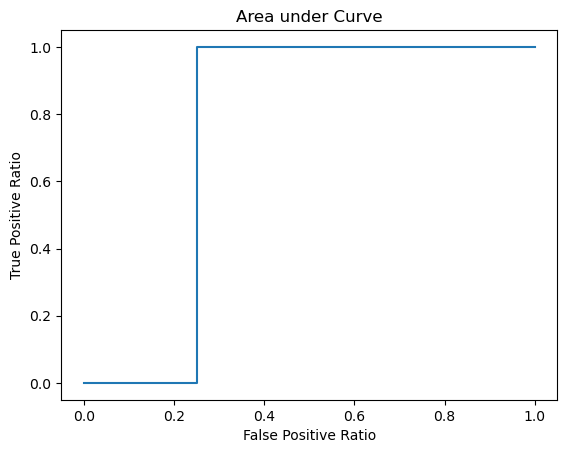

In [28]:
fprtpr = generate_fprtpr(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)

plt.plot(fprtpr[0], fprtpr[1])
plt.title('Area under Curve')
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')

In [29]:
calc_mean_auc(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)

(0.983, 0.888)

Comment:

We can see that the AUC score is quite high, this is good

# Recommendations and Conclusion

i) Discount/deals can be deployed to increase the revenue from walk in customers

ii) As member and walk in may require preplanning of their day activities prior to shopping at TCS, a "Deliver to your home within 4 hours" service could be introduced to encourage these customers to purchase items (such as soft cheese) that they otherwise would not purchase

iii) Propose TCS to synergise their stock system (Vend POS and BigCommerce) into one single system to enable better and repeatable data analysis in the future

# Further Work

i) The Recommender systems can be deployed into Vend POS

ii) The recommender system needs to be compared to the Big Commerce's RecCommerce (recommender system), prior to deployment onto BigCommerce

iii) Hypothesis testing on the performance (revenue difference) of the recommender system in 3 months to confirm customer conversion